## ***Jupyter Notebook to accompany the paper:***
    
# ***Embracing uncertainty to resolve polar wander: a North American case study***

### ***by L. C. Gallo$^1$*** *(len.gallo@gmail.com)****, M. Domeier$^1$, F. Sapienza$^2$, N. Swanson-Hysell$^3$, B. Vaes$^4$, G. Shephard$^1$, D. Gürer$^5$, T. Rolf$^1$, M. Arnaould, B. Robert, Y. Zhang, A. Eyster, L. Wu, A. van der Boon, A. Kiraly***

*(1) Centre for Earth Evolution and Dynamics, University of Oslo, Norway.*

*(2) Department of Statistics, University of California Berkeley, United States.*

*(3) Department of Earth Sciences, Faculty of Geosciences, University of California Berkeley, United States.*

*(4) Department of Earth Sciences, Faculty of Geosciences, Utrecht University, Utrecht, The Netherlands.*

*(5) Research School of Earth Sciences, Australian National University, Canberra, Australian Capital Territory, Australia.*

*(6) Laboratoire de Géologie de Lyon - Terre, Planètes, Environnement, University Lyon 1 Claude Bernard, Lyon, France*




# - Monte Carlo uncertainty propagation scheme from site-level directional data

This notebook illustrates the implementation of Section 2.2 in Gallo et al. (2023)

## * __Import scientific Python libraries__

__Import python libraries as well as functions written for the project within vgptools.__

In [4]:
import os
import numpy as np
import pandas as pd

from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs

from vgptools.utils import (spherical2cartesian, cartesian2spherical, 
                               shape, PD, eigen_decomposition,
                               GCD_cartesian, get_angle)
from vgptools.utils_visualization import plot_pole_A95, plot_pole
from vgptools.utils_classes import PC, quantiles

np.random.seed(10)

## 1. __Gather all site-level data from the collection of study-level paleopoles__
In order to gather all the directions in one DataFrame `df_directions` we follow the workflow outlined in Notebook `1_Compile.ipynb` whose output corresponds to a _.csv_ file that we import here to save computing time.

In [5]:
current_path = os.getcwd()
data_path = os.path.join(current_path, '..', 'data')
df_directions = pd.read_csv(data_path +'/vgps_filtered.csv')

## 2. The following function generates a bootstrap sample $X_b$ from the original dataset $X$. Then, it uses Monte Carlo resampling to generate for each site-level sample $X_{bi}$:
- a direction $\hat \mu_{bi}$ from the probability distribution $\text{Fisher}(\mu_i, \kappa_i)$
- an age $\hat t_{bi}$ from $N(t_i, \sigma_i)$ or $U(t_{max}, t_{max})$ (depending on whether $i$ is radiometrically or stratigraphically constrained, respectively)
- For each $X_{bi}$, calculate and store $VGP_{bi}$ and associated age $\hat t$.

In [6]:
def get_vgps_sampling_from_direction(df, study_label= 'Study',
                                     slat_label='slat', slon_label='slon', 
                                     dec_label='dec_reverse', inc_label='inc_reverse', k_label='k',
                                     mean_age_lab='mean_age', min_age_lab='min_age', max_age_lab='max_age'):
    
    '''
    Input:
    
    DF with the following site-level information: 
    - Study, site coordinates, mean direction, concentration parameter, mean age and error distribution. 
    
    Steps:
    1. generate a pseudo-sample from the original dataset using nonparametric random sampling 
    with replacement (bootstrap sample).
    2. For each row (site-level entry) in the bootstrap sample draws a random direction following 
    the kappa concentration parameter and mean direction. 
    3. Assing an age to the entry samopling from the corresponding error distribution
    3. For each row, calculates the correspongin VGP. 
    
    Note: input directions must be all in the same mode (sensu pmagPy) so that we get coherent vgps. 
    Given that we want southern hemisphere vgps, we will work with reversed (<0) inclinations (step already
    done in 0_Preprocessing.ipynb)    
    
    Output:
    
    - A DataFrame with the same size than the original dataset, with randomized parameters.  
    '''    
    Study, age_bst, decs, incs, slat, slon, indexes = [], [], [], [], [], [], [] # parameters of the pseudo-sample to be filled
    
    k_mean = df[k_label].mean() # if site-level data has no reported kappa, we take the mean of the population instead.
    
    df_pseudo = df.sample(frac = 1, replace = True) # generates a bootstrapped sample of the dataframe by randomly sampling with replacement
    
    for index, row in df_pseudo.iterrows():        
        
        # we first generate one random direction from the original entry.
        kappa = k_mean if np.isnan(row[k_label]) else row[k_label] # if we don't have kappa, we take the mean of the reported ones       
        
        directions_temp = ipmag.fishrot(k = kappa, n = 1, dec = row[dec_label], inc = row[inc_label], di_block = False)
        
        decs.append(directions_temp[0][0])
        incs.append(directions_temp[1][0])
        slat.append(row[slat_label])
        slon.append(row[slon_label])
        indexes.append(index)
        Study.append(row[study_label])
        
        # Assessing the uncertianty distribution (uniform or normal)
        if row.uncer_dist == 'uniform':
            age_bst.append(np.random.randint(np.floor(row[min_age_lab]),np.ceil(row[max_age_lab])))
        else:            
            age_bst.append(np.random.normal(row[mean_age_lab], (row[max_age_lab] - row[mean_age_lab]) / 2)) 
            # the files were completed in such a way to have min and max ages, so we take sigma as a half of that range
    
    dictionary = {
                  'Study': Study,
                  'age': age_bst,
                  'dec': decs,    
                  'inc': incs,
                  'slat': slat,
                  'slon': slon 
                  }    
    new_df = pd.DataFrame(dictionary)        
       
    #new_df['plon'] = new_df.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0], axis =1)
    new_df['plon'] = pmag.dia_vgp(new_df['dec'], new_df['inc'], 1, new_df['slat'], new_df['slon'])[0]
    
    #new_df['plat'] = new_df.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1], axis =1)
    new_df['plat'] = pmag.dia_vgp(new_df['dec'], new_df['inc'], 1, new_df['slat'], new_df['slon'])[1]
    
    # set longitude in [-180,180]
    #new_df['plon'] = new_df.apply(lambda row: row.plon - 360 if row.plon > 180 else row.plon, axis =1)
    new_df['plon'] = new_df['plon'].where(new_df['plon'] <= 180, new_df['plon'] - 360)

    new_df.index = indexes

    return new_df

2. The following function performs a Moving average and gets its descriptive parameters:

In [7]:
def moving_average_APWP(data, plon_label = 'plon', plat_label='plat', age_label = 'age',window_length=20, time_step=1, max_age=65, min_age=0):
    """
    Returns a data frame with a running mean (Moving average) APWP..
    
    Parameters: 
    - Data Frame with the folowing columns that need to be set [['vgp_lat'],['vgp_lon'],['age']]
    - time-step of the moving average (in Ma)
    - window size of the moving average (in Ma)
    
    * it also calculates descriptive parameters for the underlying distribution of VGPs within each window, e.g. : 
    - Number of VGPs,
    - Angular dispersion
    - Concentration
    - Shape (expressed as foliation, lineation, coplanarity and collinearity)
     
    * the APWP can also be described with some parameters, e.g.:
    - Apparent Polar wander rate (in degrees per Ma) between each time interval

    """
    
    mean_pole_ages = np.arange(min_age, max_age + time_step, time_step)
    
    running_means = pd.DataFrame(columns=['age','N','n_studies','k','A95','csd','plon','plat', 'foliation','lineation','collinearity','coplanarity','elong_dir',
                                         'effective_age','effective_age_std','distance2age'])
    
    for age in mean_pole_ages:
        window_min = age - (window_length / 2.)
        window_max = age + (window_length / 2.)
        poles = data.loc[(data[age_label] >= window_min) & (data[age_label] <= window_max)]
        # poles = data.query('{} >= {} & {} <= {}'.format(age_label, window_min, age_label, window_max))   
        
        if poles.empty: continue
        
        number_studies = len(poles['Study'].unique())
        mean = ipmag.fisher_mean(dec=poles[plon_label].tolist(), inc=poles[plat_label].tolist())
        
        effective_age_mean = poles[age_label].to_numpy().mean() #
        effective_age_sd = poles[age_label].to_numpy().std()
        distance2age = np.round(np.random.normal(effective_age_mean, effective_age_sd) - age)
        
        ArrayXYZ = np.array([spherical2cartesian([np.radians(i[plat_label]), np.radians(i[plon_label])]) for _,i in poles.iterrows()])        
        if len(ArrayXYZ) > 3:
            shapes = shape(ArrayXYZ)
            PrinComp=PD(ArrayXYZ)
            eVal, eVec = eigen_decomposition(ArrayXYZ)
            elong_dir = np.degrees(cartesian2spherical(eVec[:,1]))[1] # from T&K2004 (declination od the intermediate Evec)
            # mean['inc']=np.degrees(cartesian2spherical(PrinComp))[0]
            # mean['dec']=np.degrees(cartesian2spherical(PrinComp))[1]
        else:
            shapes = [np.nan,np.nan,np.nan,np.nan]
        
        if len(poles)>2: #ensures that dict isn't empty
            running_means.loc[age] = [age, mean['n'], number_studies, mean['k'],mean['alpha95'], mean['csd'], mean['dec'], mean['inc'], 
                                      shapes[0], shapes[1], shapes[2], shapes[3], elong_dir,
                                     effective_age_mean, effective_age_sd, distance2age]
    # Set longitudes in [-180, 180]
    running_means['plon'] = running_means.apply(lambda row: row.plon - 360 if row.plon > 180 else row.plon, axis =1)   
    
    # The following block calculates rate of polar wander (degrees per million years) 
    running_means['PPcartesian'] = running_means.apply(lambda row: spherical2cartesian([np.radians(row['plat']),np.radians(row['plon'])]), axis = 1)
    running_means['PP_prev'] = running_means['PPcartesian'].shift(periods = 1)
    running_means['PP_next'] =  running_means['PPcartesian'].shift(periods = -1)
    running_means['GCD'] = running_means.apply(lambda row: np.degrees(GCD_cartesian(row['PP_prev'], row['PPcartesian'])), axis = 1)
    running_means['APW_rate'] = running_means['GCD']/running_means['age'].diff()
    # Calculate a 'kink' angle for each position of the path
    running_means['angle'] = running_means.apply(lambda row: get_angle(row['PP_prev'], row['PPcartesian'], row['PP_next']), axis = 1)

    running_means = running_means.drop(['PPcartesian', 'PP_prev', 'PP_next'], axis=1)      
    running_means.reset_index(drop=1, inplace=True)
    
    #set the present day field for the present
    running_means['plat'] = np.where(running_means['age']==0, -90, running_means['plat'])
    running_means['plon'] = np.where(running_means['age']==0, 0, running_means['plon'])
    
    return running_means


3. The following function performs the previous procedure a number of times a stores for each run the Moving Average along with their descriptive parameters

In [8]:
def ensemble_RMs(df_vgps_original, n_sims = 100, 
                 study_label= 'Study', slat_label='slat', slon_label='slon', 
                 dec_label='dec_reverse', inc_label='inc_reverse', k_label='k',
                 mean_age_lab='mean_age', min_age_lab='min_age', max_age_lab='max_age',
                 plon_label = 'plon', plat_label='plat', age_label = 'age',
                 window_length=20, time_step=1, max_age=65, min_age=0):
    
    '''
    This function . . . 
    '''
    
    running_means_global = pd.DataFrame(columns=['run','N','k','A95','csd','foliation','lineation','collinearity','coplanarity'])
    
    for i in range(n_sims):
    
        # Generate a pseudo-sample of the original dataset in which every entry is a pseudo-sample taken for the error PDF
        pseudo_df = get_vgps_sampling_from_direction(df_vgps_original, study_label= study_label,
                                             slat_label=slat_label, slon_label=slon_label, 
                                             dec_label=dec_label, inc_label=inc_label, k_label=k_label,
                                             mean_age_lab=mean_age_lab, min_age_lab=min_age_lab, max_age_lab=max_age_lab)

        # Construct a Moving Average on the former data-set
        RM = moving_average_APWP(pseudo_df, plon_label = 'plon', plat_label='plat', age_label = 'age', 
                            window_length=window_length, time_step=time_step, max_age=max_age, min_age=min_age)
 
        RM['run'] = float(i)
        running_means_global = running_means_global.append(RM, ignore_index=True)

    running_means_global['plon'] = running_means_global['plon'].where(running_means_global['plon'] <= 180, running_means_global['plon'] - 360)
    return running_means_global

# Run an ensemble of Moving Avergaes:

First, we set the parameters of the moving average

In [9]:
# Set the parameters for the Moving average
window_length= 21
time_step= 1 
max_age= 65
min_age= 0

## 4. We now proceed to run the workflow a great number of times in order to to get the ensemble statistics.

In [10]:
%%time
np.random.seed(10)
df_RM_ensemble = ensemble_RMs(df_directions, n_sims = 100,
                 study_label= 'Study', slat_label='slat', slon_label='slon',
                 dec_label='dec_reverse', inc_label='inc_reverse', k_label='k',
                 mean_age_lab='mean_age', min_age_lab='min_age', max_age_lab='max_age',
                 plon_label = 'plon', plat_label='plat', age_label = 'age',
                 window_length=window_length, time_step=time_step, max_age=max_age, min_age=min_age)

CPU times: user 14min 37s, sys: 2.35 s, total: 14min 40s
Wall time: 14min 40s


In [11]:
df_RM_ensemble.head()

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,n_studies,plon,plat,elong_dir,effective_age,effective_age_std,distance2age,GCD,APW_rate,angle
0,0.0,320.0,20.803249,1.765831,17.759038,0.538568,2.771076,5.145265,3.309644,0.0,14.0,0.000000,-90.000000,166.522416,2.775255,2.621647,1.0,NaN,NaN,NaN
1,0.0,322.0,20.653237,1.767019,17.823416,0.539228,2.763337,5.124615,3.302565,1.0,14.0,-70.827969,-88.008611,165.271230,2.826068,2.691369,3.0,0.091952,0.091952,NaN
2,0.0,322.0,20.653237,1.767019,17.823416,0.539228,2.763337,5.124615,3.302565,2.0,14.0,-70.827969,-88.008611,165.271230,2.826068,2.691369,0.0,0.000000,0.000000,NaN
3,0.0,323.0,20.462398,1.772896,17.906337,0.551682,2.749108,4.983139,3.300790,3.0,14.0,-69.094205,-87.916915,164.433500,2.857566,2.745999,0.0,0.110475,0.110475,NaN
4,0.0,323.0,20.462398,1.772896,17.906337,0.551682,2.749108,4.983139,3.300790,4.0,14.0,-69.094205,-87.916915,164.433500,2.857566,2.745999,-0.0,0.000000,0.000000,NaN


# Visualization

### First we need to calculate the time-varying Ensemble statistics 
We take advantage of the groupby method to perform the statistics of each parameter of interest in the entire datade grouped by Age

quantile and PC are classet that aid this calculations

In [12]:
# Set the level confidence at which we want to work 
quantile = 95

# Since the Latitude and Longitude covaries, we need to calculate the Principal component for each timre-dependant point Cloud 
ensemble_PC = PC(df_RM_ensemble,"age","plat","plon") # set principal component for each Age

# Ensemble Statistics (quantiles) for each time-varying parameter:
ensemble_lat = quantiles(df_RM_ensemble,"age","plat")  # set quantiles of latitude groupedby age for visualization purposes
ensemble_lon = quantiles(df_RM_ensemble,"age","plon")  # set quantiles of latitude groupedby age for visualization purposes

#Ensemble's parameters (e.g. Apparent polar wander rate, age difference)
ensemble_apw = quantiles(df_RM_ensemble,"age","APW_rate") # set quantiles of latitude groupedby age for visualization purposes
ensemble_age_diff = quantiles(df_RM_ensemble,"age","distance2age") # set quantiles of latitude groupedby age for visualization purposes

## The actual path in Sourthern coordinates

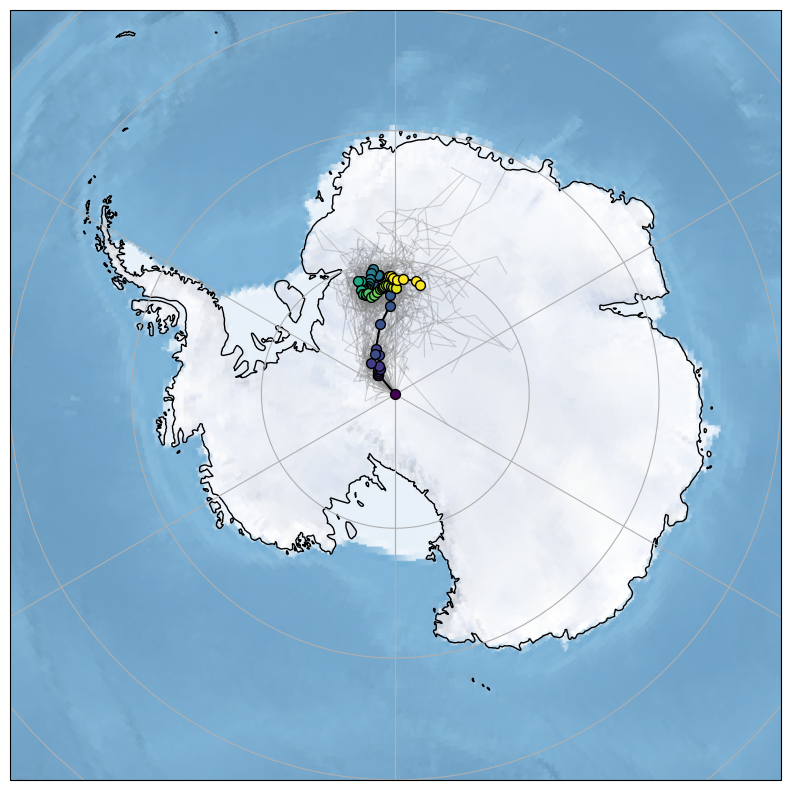

In [13]:
# Visualization
extent = [-180,180,-60,-60]
fig = plt.figure(figsize=(20,10))
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
ax = plt.axes(projection=proj)
ax.coastlines(), ax.stock_img(), ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())



# A black path for the time-varying Principal Component.
plt.plot(ensemble_PC.PC(quantile)[0].tolist(), ensemble_PC.PC(quantile)[1].tolist(),transform = ccrs.Geodetic(), color = "black", alpha = 1, linewidth=1.5, zorder=1)

# Color coded Paleopoles and 95 circles.
# for i in zip(ensemble_PC.PC()[1].tolist(), ensemble_PC.PC()[0].tolist(),ensemble_PC.PC()[2].tolist(), df_RM_ensemble['age'].unique().transpose()):
#     plot_pole_A95(i[0],i[1],i[2],i[3],0,60,ax)
    
for i in zip(ensemble_PC.PC(quantile)[1].tolist(), ensemble_PC.PC(quantile)[0].tolist(),ensemble_PC.X.tolist(), df_RM_ensemble['age'].unique().transpose()):
    plot_pole(i[0],i[1],i[2],0,60,ax)
    
# Runs in grey (just plotting 50 runs)
for run, df_run in df_RM_ensemble[df_RM_ensemble['run']<50].groupby('run'):
    plt.plot(df_run.plon.tolist(), df_run.plat.tolist(),transform = ccrs.Geodetic(), color = "grey", alpha = 0.3, linewidth=0.8, zorder=0)


# plt.savefig(os.path.join(current_path, '..')  + '/figures/3/path.svg', dpi =600, bbox_inches='tight')
plt.show()

### Ensemble Statistics and Principal components

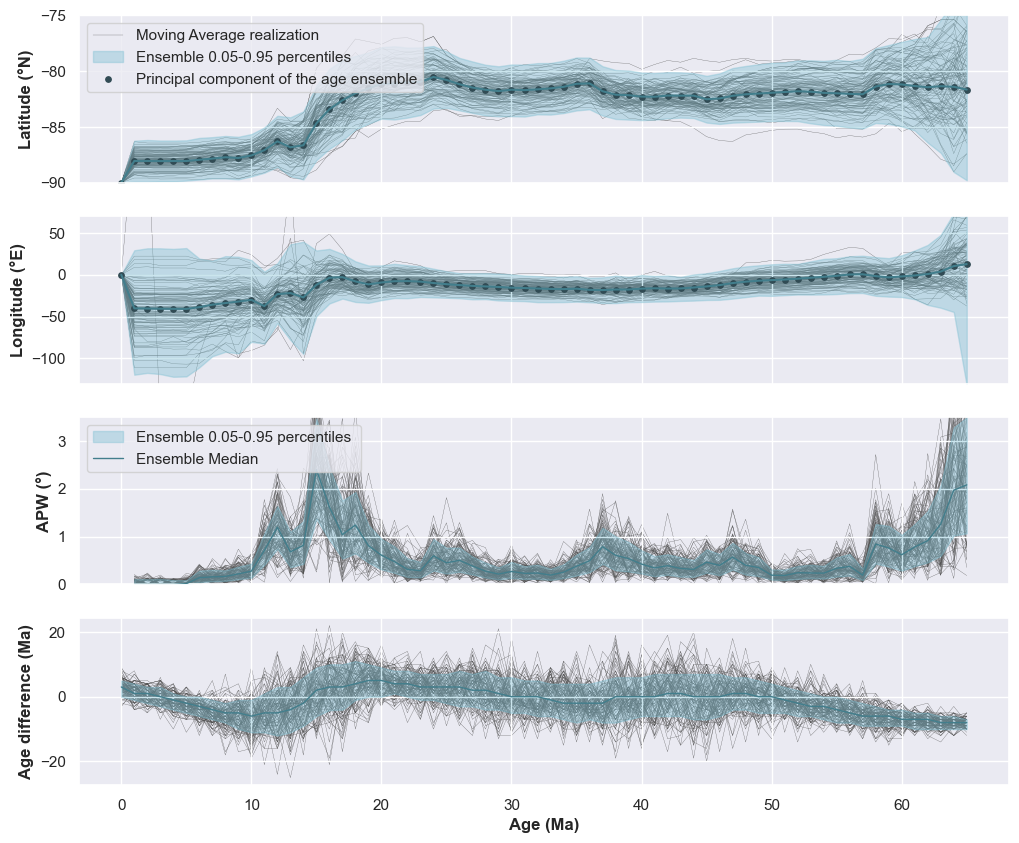

In [14]:
sns.reset_orig
sns.set_theme(style="darkgrid")
# sns.set_theme(style="white", palette=None)
fig, axes = plt.subplots(4, 1, figsize=(12,10), sharex=True)

# Set Axis Labels
axes[0].set_ylabel(r'Latitude (°N)', fontweight ='bold', fontsize = 12)
axes[1].set_ylabel(r'Longitude (°E)', fontweight ='bold', fontsize = 12)
axes[2].set_ylabel(r'APW (°)', fontweight ='bold', fontsize = 12)

axes[3].set_ylabel(r'Age difference (Ma)', fontweight ='bold', fontsize = 12)

# axes[1].set_ylabel(r'APW (°)', fontweight ='bold', fontsize = 12)
axes[3].set_xlabel(r'Age (Ma)', fontweight ='bold', fontsize = 12)

# LATITUDES 
df_RM_ensemble_50 = df_RM_ensemble[df_RM_ensemble['run'].isin(range(0,100))]

for run, df_run in df_RM_ensemble_50.groupby('run'):
    axes[0].plot(df_run.age.tolist(), df_run.plat.tolist(), color="#4F4F4F", zorder =0, linewidth=0.2)
axes[0].plot(df_run.age.tolist(), df_run.plat.tolist(), color="#4F4F4F", zorder =0, linewidth=0.2, label = 'Moving Average realization')
axes[0].fill_between(ensemble_PC.X, ensemble_PC.Lat_Lon_bounds(quantile)[2], ensemble_PC.Lat_Lon_bounds(quantile)[3], color= "#7DBFD2", alpha=.40, zorder =1, label=f"Ensemble {1-quantile/100:.2f}-{quantile/100:.2f} percentiles ")
# axes[0].plot(ensemble_PC.X, ensemble_PC.Lat_Lon_bounds(quantile)[2],color="#427E8C", zorder =3, linewidth=0.2)
# axes[0].plot(ensemble_PC.X, ensemble_PC.Lat_Lon_bounds(quantile)[3],color="#427E8C", zorder =3, linewidth=0.2)
axes[0].scatter(ensemble_PC.X, ensemble_PC.PC(quantile)[1],color="#314B54", s = 15,  label = 'Principal component of the age ensemble')  
axes[0].plot(ensemble_PC.X, ensemble_PC.PC(quantile)[1],color="#427E8C")  
    
# LONGITUDES     
for run, df_run in df_RM_ensemble_50.groupby('run'):
    axes[1].plot(df_run.age.tolist(), df_run.plon.tolist(), color="#4F4F4F", zorder =0, linewidth=0.2)
axes[1].plot(df_run.age.tolist(), df_run.plon.tolist(), color="#4F4F4F", zorder =0, linewidth=0.2, label = 'Moving Average realization')
axes[1].fill_between(ensemble_lon.X, ensemble_PC.Lat_Lon_bounds(quantile)[0], ensemble_PC.Lat_Lon_bounds(quantile)[1], color= "#7DBFD2", alpha=.40, zorder =1, label=f"Ensemble {1-quantile/100:.2f}-{quantile/100:.2f} percentiles ")
# axes[1].plot(ensemble_PC.X, ensemble_lon.q16,color="#590E0E", zorder =3, linewidth=0.2)
axes[1].scatter(ensemble_PC.X, ensemble_PC.PC(quantile)[0],color="#314B54", s = 15,  label = 'Principal component of the age ensemble')
axes[1].plot(ensemble_PC.X, ensemble_PC.PC(quantile)[0],color="#427E8C")  

# APW (°)     
for run, df_run in df_RM_ensemble_50.groupby('run'):
    axes[2].plot(df_run.age.tolist(), df_run.APW_rate.tolist(), color="#4F4F4F", zorder =0, linewidth=0.2)
# axes[1,1].plot(df_run.age.tolist(), df_run.plon.tolist(), color="#4F4F4F", zorder =0, linewidth=0.2, label = 'Moving Average realization')
axes[2].fill_between(ensemble_apw.X, ensemble_apw.q16,ensemble_apw.q84, color= "#7DBFD2", alpha=.40, zorder =1, label=f"Ensemble {1-quantile/100:.2f}-{quantile/100:.2f} percentiles ")
axes[2].plot(ensemble_apw.X, ensemble_apw.q50,color="#427E8C", zorder =3, linewidth=1, label="Ensemble Median")
# axes[1,1].plot(ensemble_PC.X, ensemble_lon.q16,color="#590E0E", zorder =3, linewidth=0.2)

# Aage difference (Ma)
for run, df_run in df_RM_ensemble_50.groupby('run'):
    axes[3].plot(df_run.age.tolist(), df_run.distance2age.tolist(), color="#4F4F4F", zorder =0, linewidth=0.2)
# axes[1,1].plot(df_run.age.tolist(), df_run.plon.tolist(), color="#4F4F4F", zorder =0, linewidth=0.2, label = 'Moving Average realization')

axes[3].fill_between(ensemble_age_diff.X, ensemble_age_diff.q16,ensemble_age_diff.q84, color= "#7DBFD2", alpha=.40, zorder =1, label=f"Ensemble {1-quantile/100:.2f}-{quantile/100:.2f} percentiles ")
axes[3].plot(ensemble_age_diff.X, ensemble_age_diff.q50,color="#427E8C", zorder =3, linewidth=1, label="Ensemble Median")

# axes[1,1].plot(ensemble_PC.X, ensemble_lon.q16,color="#590E0E", zorder =3, linewidth=0.2)

axes[0].set_ylim(-90,-75)
axes[1].set_ylim(-130,70)
axes[2].set_ylim(0,3.5)
axes[0].legend(loc="upper left")
axes[2].legend(loc="upper left")
# plt.savefig(os.path.join(current_path, '..') + '/figures/3/ensemble.svg', dpi =600, bbox_inches='tight')   

## How a single run looks like?

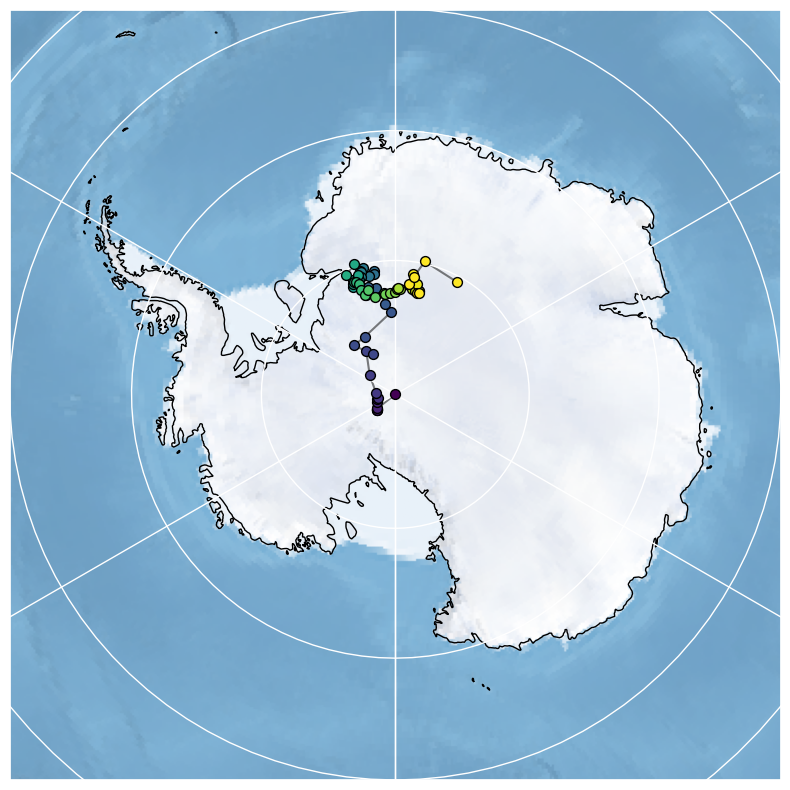

In [15]:
np.random.seed(18)

# Generate a pseudo-sample of the original dataset in which every entry is a pseudo-sample taken for the error PDF
pseudo_df = get_vgps_sampling_from_direction(df_directions, study_label= 'Study',
                                     slat_label='slat', slon_label='slon', 
                                     dec_label='dec_reverse', inc_label='inc_reverse', k_label='k',
                                     mean_age_lab='mean_age', min_age_lab='min_age', max_age_lab='max_age')

# Construct a Moving Average on the former data-set
RM = moving_average_APWP(pseudo_df, plon_label = 'plon', plat_label='plat', age_label = 'age', 
                    window_length=window_length, time_step=time_step, max_age=max_age, min_age=min_age)

# Visualization
extent = [-180,180,-60,-60]
fig = plt.figure(figsize=(20,10))
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
ax = plt.axes(projection=proj)    
ax.coastlines(), ax.stock_img(), ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())

plt.plot(RM.plon, RM.plat,transform = ccrs.Geodetic(), color = "black", alpha = 0.5)
for i in zip(RM.plat, RM.plon, RM['age'].unique().transpose()):
    plot_pole(i[0],i[1],i[2],0,60,ax)
plt.show()

## Export the Apparent Polar Wander path as csv file

In [30]:
apwp = {'Age': ensemble_PC.X,
           'Plat': ensemble_PC.PC(quantile)[1],
           'Plon': ensemble_PC.PC(quantile)[0],
           'Theta 95': ensemble_PC.PC(quantile)[2],
           'max lat': ensemble_PC.Lat_Lon_bounds(quantile)[3],
           'min lat': ensemble_PC.Lat_Lon_bounds(quantile)[2],
           'max lon': ensemble_PC.Lat_Lon_bounds(quantile)[1],
           'min lon': ensemble_PC.Lat_Lon_bounds(quantile)[0],           
          }
df_apwp = pd.DataFrame(apwp)

In [31]:
df_apwp.to_csv(data_path +'/NAM_Cenozoic_APWP.csv', index = False)